### Importing Libraries

In [1]:
import pandas as pd
import joblib
import operator
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

### Declaring methods

In [2]:
def feature_engineering_perm(data, fe_imp):
    '''
    This method is used to engineer new features(+, -, *, /, cos, cosh, sin , sinh, exp of existing features) from the given
    list of feature transformations and the dataset.
    
    ----------------------
    Parameter
    data    : The input dataset.
    
    fe_imp  : A pandas series containing the top important feature combinations of arithmetic and trignometric
              operations.
              
    ----------------------                       
    Returns
    data_fe : A pandas DataFrame containing dataset with only the given transformed features.
    '''
        
    data_fe = pd.DataFrame()
    #defining a dict of operation name and the operations
    op_dict = {'+': operator.add, '-': operator.sub, '*': operator.mul, '/': operator.truediv,
              'cos': np.cos, 'sin': np.sin, 'cosh': np.cosh, 'sinh': np.sinh, 'exp': np.exp}
    
    for i in fe_imp.index:
        oper = ''.join(re.findall('[^0-9_]', i)) #extracting the arith or trig operation from the name of col.Eg:12+32 or cos_21
        if(not oper):
            data_fe[i] = data[i].copy() #if there is no operation involved then the same feature is taken as it is.
        else:
            op = op_dict[oper]
            if('_' in i): #checking if the operation is trig
                cols = i.split(oper+'_') #splitting based on the '_' Eg: cos_12 -> cos, 12
                data_fe[i] = op(data[cols[1]]) #appying the trig operation
            else: 
                cols = i.split(oper) #splitting based on the operation Eg: 12+13 -> splitting on '+' -> 12,13
                data_fe[i] = op(data[cols[0]], data[cols[1]]) #applying the arth operation
                
        if(data_fe[i].isin([np.inf, -np.inf, np.nan]).any()):
            data_fe[i].replace([np.inf, -np.inf], np.nan, inplace=True) #replaces the inf, -inf to nan(coz mean of r.v with inf is nan)
            data_fe[i].replace(np.nan, data_fe[i].mean(), inplace=True) # replaces nan with mean val
        

    return data_fe

### Importing Data

In [3]:
train = pd.read_csv('dont-overfit-ii/train.csv')
x_train = train.drop(['id','target'], axis=1)
y_train = pd.DataFrame(train['target'])


feature_imp = pd.read_csv('dont-overfit-ii/processed_data/feature_importance.csv', index_col = 'Unnamed: 0')

In [4]:
#loading the best performing model- EngFe100_Cor_LogisticRegression_1
clf = joblib.load('saved_models/EngFe100_Cor_LogisticRegression_1.sav')

In [5]:
#Engineering the features required for the best model
top_features = feature_imp['abs_correlation'].sort_values(ascending = False)[:100]
x_train_fe = feature_engineering_perm(x_train, top_features)

In [6]:
#predicting the prob. of class 1 of the data points
y_train_pred = clf.predict_proba(x_train_fe)[:, 1:].reshape(-1)

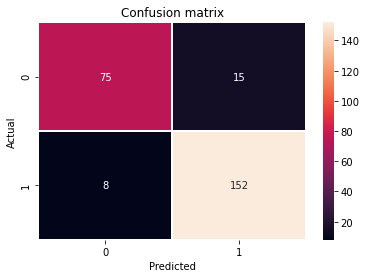

In [7]:
#Finding the confusion matrix
y_train_pred_ =list(map(lambda a: 0 if a < 0.5 else 1, y_train_pred))
cm = confusion_matrix(y_train, y_train_pred_)
sns.heatmap(cm, annot=True,fmt="d",linewidths = 1)
plt.xlabel('Predicted') # x-axis label with fontsize 15
plt.ylabel('Actual') # y-axis label with fontsize 15
plt.title('Confusion matrix')
plt.show()

In [8]:
#Finding the points that belong to TP, TN, FP, FN
points_test = {'TP':[],'TN':[],'FP':[],'FN':[]}
for i in range(0,len(y_train_pred_)):
    if(y_train_pred_[i] == y_train.loc[i, 'target']):
        if(y_train_pred_[i] == 1):
            points_test['TP'].append(i)
            y_train.loc[(i), 'cm'] = 'TP'
        elif(y_train_pred_[i] == 0):
            points_test['TN'].append(i)
            y_train.loc[i, 'cm'] = 'TN'
    elif(y_train_pred_ [i]!= y_train.loc[i, 'target']):
        if(y_train_pred_[i] == 1):
            points_test['FP'].append(i)
            y_train.loc[i, 'cm'] = 'FP'
        elif(y_train_pred_[i] == 0):
            points_test['FN'].append(i)
            y_train.loc[i, 'cm'] = 'FN'
            
print('TP',len(points_test['TP']))
print('TN',len(points_test['TN']))
print('FP',len(points_test['FP']))
print('FN',len(points_test['FN']))

TP 152
TN 75
FP 15
FN 8


Observations:
 - There are 23 misclassified points when we choose 0.5 as threshold. The 23 points constitutes of 9% of the overall data points

In [9]:
#Adding addional info like pred_prob, pred_val, misclassified to the y_train dataframe
y_train['misclassified'] = [False if 'T' in i else True for i in y_train['cm']]
y_train['pred_prob'] = y_train_pred
y_train['pred_val'] = y_train_pred_
y_train

,target,cm,misclassified,pred_prob,pred_val
0,1.0,TP,False,0.948776,1
1,0.0,TN,False,0.250628,0
2,1.0,TP,False,0.923687,1
3,1.0,TP,False,0.730461,1
4,1.0,TP,False,0.788213,1
...,...,...,...,...,...
245,0.0,FP,True,0.613766,1
246,0.0,TN,False,0.133680,0
247,0.0,FP,True,0.567187,1
248,1.0,TP,False,0.797524,1


In [10]:
#concatenating the y_train and the x_train
train_perf =  pd.concat([x_train,y_train], axis=1)
train_perf

,0,1,2,3,4,5,6,7,8,9,...,295,296,297,298,299,target,cm,misclassified,pred_prob,pred_val
0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,...,-2.097,1.051,-0.414,1.038,-1.065,1.0,TP,False,0.948776,1
1,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,...,-1.624,-0.458,-1.099,-0.936,0.973,0.0,TN,False,0.250628,0
2,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,0.137,0.183,...,-1.165,-1.544,0.004,0.800,-1.211,1.0,TP,False,0.923687,1
3,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,0.503,0.274,...,0.467,-0.562,-0.254,-0.533,0.238,1.0,TP,False,0.730461,1
4,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,-0.012,2.198,...,1.378,1.246,1.478,0.428,0.253,1.0,TP,False,0.788213,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,-1.199,0.466,-0.908,2.771,1.631,0.931,0.182,-0.652,-0.512,0.400,...,-0.243,0.525,0.281,-0.255,-1.136,0.0,FP,True,0.613766,1
246,0.237,0.233,-0.380,-1.748,0.839,-0.721,-0.114,0.005,-1.788,1.416,...,1.004,-0.979,0.007,0.112,-0.558,0.0,TN,False,0.133680,0
247,1.411,-1.465,0.119,0.583,1.634,-0.207,1.173,1.622,-0.071,-0.695,...,-0.727,0.461,0.760,0.168,-0.719,0.0,FP,True,0.567187,1
248,0.620,1.040,0.184,-0.570,-0.087,-0.748,-1.559,-0.553,0.552,1.284,...,0.478,-0.910,-0.805,2.029,-0.423,1.0,TP,False,0.797524,1


In [11]:
#finding the mask of the positive, negative, correctly classified and misclassified points
points_0 = y_train['target'] == 0
points_1 = y_train['target'] == 1
points_t = y_train['misclassified'] == False
points_f = y_train['misclassified'] == True

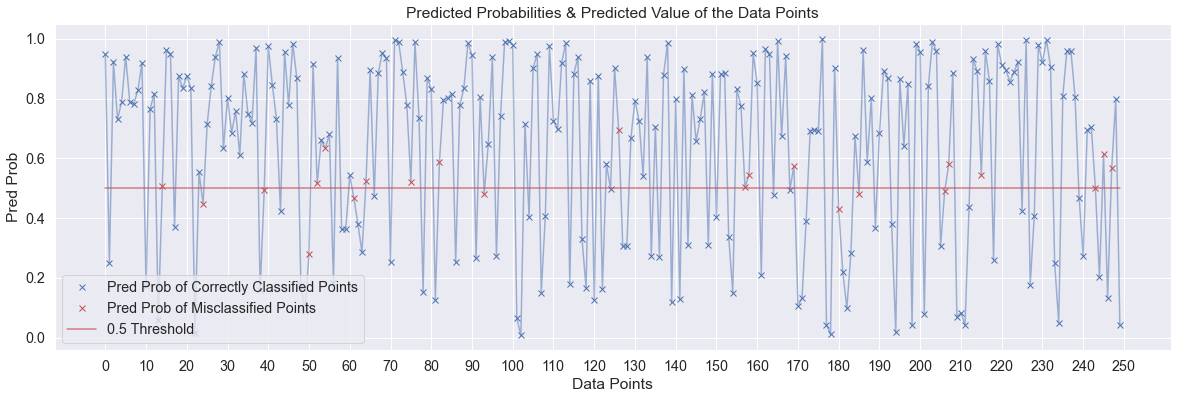

In [12]:
#plotting the pred value of the data points
sns.set(font_scale=1.3)
plt.figure(figsize=(20,6))

plt.plot(train_perf[points_t]['pred_prob'],'xb', label = 'Pred Prob of Correctly Classified Points')
plt.plot(train_perf['pred_prob'],'b', alpha = 0.5)

#taking the features that got p-value less that 0.05
plt.plot(train_perf[points_f]['pred_prob'],'xr', label = 'Pred Prob of Misclassified Points')

plt.plot([0.5]*250,'r', label = '0.5 Threshold', alpha = 0.7)

plt.title('Predicted Probabilities & Predicted Value of the Data Points')
plt.legend()
plt.xlabel('Data Points')
plt.ylabel('Pred Prob')
plt.xticks(range(0,251,10))
plt.show()

Observations:
 - The most of the misclassified points are near the 0.5 threshold with which we classified them, but that must have not affected our performance metric AUC score(as it is threshold independent method).

### Multivariate analysis using T-SNE(Original Feature Dimension)

In [13]:
#Using T-sne to see if the misclassified has any patterns in it.
model = TSNE(n_components=2, random_state=0, perplexity=15,  n_iter=10000)

tsne_data = model.fit_transform(x_train)
tsne_data = np.hstack((tsne_data, y_train))
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label', 'cm', 'misclassified', 'pred_prob', 'pred_val'))

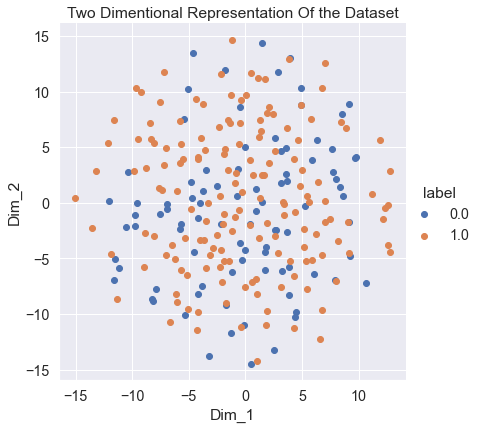

In [14]:
#plotting the lower dimentional rep of data points to see if there are any pattern in it
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Two Dimentional Representation Of the Dataset')
plt.show()

Observations:
- There seems to be no pattern or no region among the positive and the negative points in the lower dimentional representation of the data.

### Multivariate analysis using T-SNE(Engineered Feature Dimension)

In [15]:
#Using T-sne to see if the misclassified points has any patterns in it.
model_tfd = TSNE(n_components=2, random_state=0, perplexity=15,  n_iter=10000)

tsne_data_tfd = model.fit_transform(x_train_fe)
tsne_data_tfd = np.hstack((tsne_data_tfd, y_train))
tsne_df_tfd = pd.DataFrame(data=tsne_data_tfd, columns=('Dim_1', 'Dim_2', 'label', 'cm', 'misclassified', 'pred_prob', 'pred_val'))

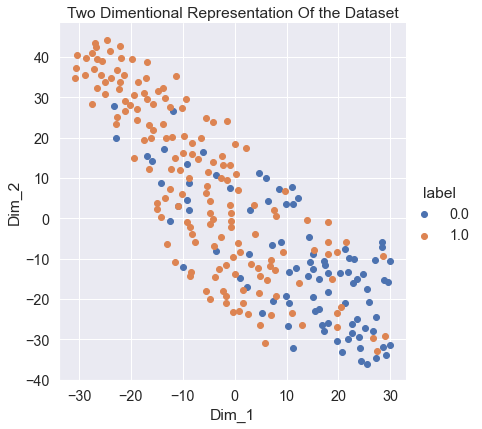

In [16]:
#plotting the lower dimentional rep of feature engineered data points to see if there are any pattern in it
sns.FacetGrid(tsne_df_tfd, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Two Dimentional Representation Of the Dataset')
plt.show()

Observations:
- After the feature engineering, we can see that the most of the positive and the negative points are seperable in the lower dimentional representation of the transformed(Engineered features) data space.

### Finding Outlier points

In [17]:
#Finding outlier using LocalOutlierFactor method for the negative points alone
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof.fit_predict(x_train_fe[points_0])
x_lof_scores = lof.negative_outlier_factor_
lof_outlier_0= [True if i < lof.offset_ else False for i in x_lof_scores]

#Finding outlier using LocalOutlierFactor method for the positive points alone
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof.fit_predict(x_train_fe[points_1])
x_lof_scores = lof.negative_outlier_factor_
lof_outlier_1= [True if i < lof.offset_ else False for i in x_lof_scores]

#adding the points that are outliers in a dataframe to combine both the negative and the positive points
outlier = pd.DataFrame([[0]]*250, columns = ['lof_outlier'])
outlier.loc[points_1,'lof_outlier'] = np.array(lof_outlier_1)
outlier.loc[points_0,'lof_outlier'] = np.array(lof_outlier_0)

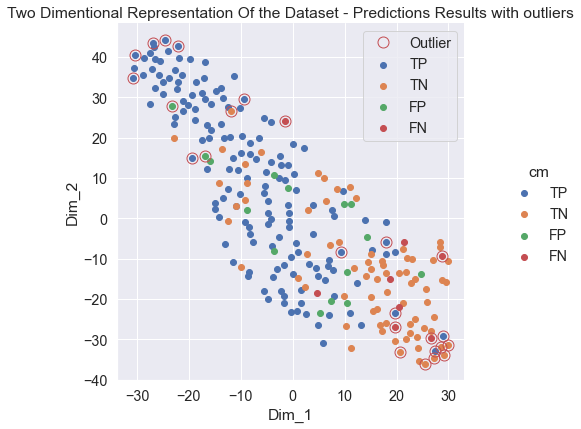

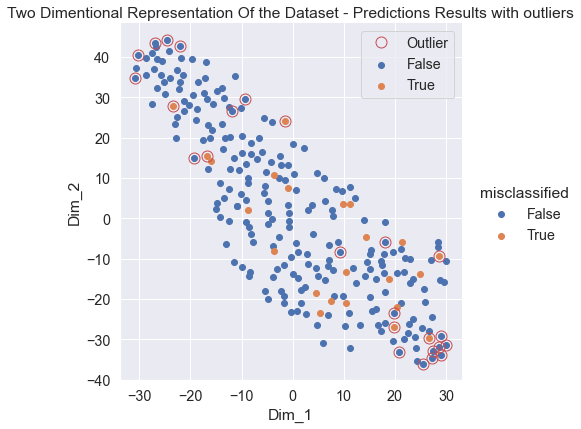

In [18]:
#plotting TP, TN, FP, FN of all data points along with the outlier points to see if there are any pattern in it
sns.FacetGrid(tsne_df_tfd, hue="cm", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.plot(tsne_df_tfd['Dim_1'][outlier['lof_outlier'] == True],
         tsne_df_tfd['Dim_2'][outlier['lof_outlier'] == True],
         'or', label = 'Outlier',mfc='none', markersize=11)
plt.title('Two Dimentional Representation Of the Dataset - Predictions Results with outliers')
plt.legend()
plt.show()


#plotting misclassified and correctly classified points along with outliers to see if there are any pattern in it
sns.FacetGrid(tsne_df_tfd, hue="misclassified", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.plot(tsne_df_tfd['Dim_1'][outlier['lof_outlier'] == True],
         tsne_df_tfd['Dim_2'][outlier['lof_outlier'] == True],
         'or', label = 'Outlier',mfc='none', markersize=11)
plt.title('Two Dimentional Representation Of the Dataset - Predictions Results with outliers')
plt.legend()
plt.show()

Observations:
- From the above plots of the lower dimentions representations we can see that only some of the misclassified points are found to be ouliers or points in the less dense region for that particular class(found using local outlier factor).
- The False negative and the True negative points mostly belongs to the other class region suggests that the model(logisic regression) can be improved if experiment with more feature engineering which gives more seperation between positive and negative points.